# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
msn10 = pd.read_csv("data/msn_10_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn11 = pd.read_csv("data/msn_11_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn12 = pd.read_csv("data/msn_12_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn14 = pd.read_csv("data/msn_14_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn29 = pd.read_csv("data/msn_29_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn37 = pd.read_csv("data/msn_37_fuel_leak_signals_preprocessed.csv", delimiter=';')
msn53 = pd.read_csv("data/msn_53_fuel_leak_signals_preprocessed.csv", delimiter=';')

In [63]:
combined = pd.concat([msn10, msn11, msn12, msn14, msn29, msn37, msn53])

In [64]:
# Setting index as datetime
combined['UTC_TIME'] = pd.to_datetime(combined['UTC_TIME'])
combined = combined.set_index("UTC_TIME")

In [65]:
# Dropping Duplicates
combined = combined.drop_duplicates()

# Dropping Null Roles
combined = combined.dropna(subset=combined.columns)

In [66]:
# Identify Different Flights within the same flight number
# ========================================================

# Identify when a new flight starts (FLIGHT_PHASE_COUNT resets within each Flight)
combined['NEW_FLIGHT'] = combined.groupby('Flight')['FLIGHT_PHASE_COUNT'].diff().lt(0)

# Assign a unique flight instance number per Flight
combined['FLIGHT_INSTANCE'] = combined.groupby('Flight')['NEW_FLIGHT'].cumsum()

# New column to identify unique flights
combined['FLIGHT_ID'] = combined['Flight'].astype(str) + "_" + combined['FLIGHT_INSTANCE'].astype(str)

In [67]:
# Filter out only fro flight phase 8 - Cruise
combined = combined[combined["FLIGHT_PHASE_COUNT"]==8.0]

In [68]:
combined.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376554 entries, 2015-07-21 03:51:31 to 2018-04-22 11:45:45
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   FUEL_USED_2         376554 non-null  float64
 1   FUEL_USED_3         376554 non-null  float64
 2   FUEL_USED_4         376554 non-null  float64
 3   FW_GEO_ALTITUDE     376554 non-null  float64
 4   VALUE_FOB           376554 non-null  float64
 5   VALUE_FUEL_QTY_CT   376554 non-null  float64
 6   VALUE_FUEL_QTY_FT1  376554 non-null  float64
 7   VALUE_FUEL_QTY_FT2  376554 non-null  float64
 8   VALUE_FUEL_QTY_FT3  376554 non-null  float64
 9   VALUE_FUEL_QTY_FT4  376554 non-null  float64
 10  VALUE_FUEL_QTY_LXT  376554 non-null  float64
 11  VALUE_FUEL_QTY_RXT  376554 non-null  float64
 12  FLIGHT_PHASE_COUNT  376554 non-null  float64
 13  FUEL_USED_1         376554 non-null  float64
 14  Flight              376554 non-null  float64
 15  

# Feature Engineering

**THINGS TO CONSIDER**

| **Column Name** | **Description** |
| ----------- | ----------- |
| `VALUE_FOB` | Fuel on Board |
| `VALUE_FUEL_QTY_CT` | Central Tank |
| `VALUE_FUEL_QTY_FT1` | Fuel Quantity Feed Tank 1 (Engine 1) |
| `VALUE_FUEL_QTY_FT2` | Fuel Quantity Feed Tank 2 (Engine 2) |
| `VALUE_FUEL_QTY_FT3` | Fuel Quantity Feed Tank 3 (Engine 3) |
| `VALUE_FUEL_QTY_FT4` | Fuel Quantity Feed Tank 1 (Engine 4) |
| `VALUE_FUEL_QTY_LXT` | Fuel Quantity Transfer Tank Left |
| `VALUE_FUEL_QTY_RXT` | Fuel Quantity Transfer Tank Right |
| `FUEL_USED_1` | Fuel Used (Engine 1) |
| `FUEL_USED_2` | Fuel Used (Engine 2) |
| `FUEL_USED_3` | Fuel Used (Engine 3) |
| `FUEL_USED_4` | Fuel Used (Engine 4) |

Based on typical Airbus engining, we ca thus assume the fllowing:

| **Column Name** | **Left vs Right Side**|
| ----------- | ----------- |
| `VALUE_FUEL_QTY_LXT` | Left Outer fuel Quantity |
| `VALUE_FUEL_QTY_FT1` | Left Inner Fuel Quanitity  |
| `VALUE_FUEL_QTY_FT2` | Left Inner Fuel Quantity |
| `VALUE_FUEL_QTY_RXT` | Right Outer Fuel Quantity |
| `VALUE_FUEL_QTY_FT3` | Right Inner Fuel Quantity |
| `VALUE_FUEL_QTY_FT4` | Right Inner Fuel Quantity |

Additionally, from our research:
- Fuel can be transfered from hte outertanks to the inner tanks
- This transfer happens when the inner tanks meet a certain threshold of fuel quantity, triggering the transfer from outer to inner tanks
- Fuel can be transfer from the heavier side to the lighter side to maintain balance
- Pilot and crew can detect a fuel leak when:
    1. Fuel at any point is significantly less than the predicted quantity at that time
    2. Fuel flow indiciations are significantly hgher on one engine in comparison to the other
    3. There is a significant differece between the fuel quantities between tanks in the left and right wing
    4. There is a fuel imbalance of a certain threshold or more in a specific time periond (ie. 230kg or more difference within 30 minutes.)


### Fuel Discrepancy

In [69]:
# Calculating Fuel Discrepancy
# ============================

# Sort by time
combined = combined.sort_index()

# Find the initial fuel value for each flight instance
combined['START_FOB'] = combined.groupby('FLIGHT_ID')['VALUE_FOB'].transform('first')

# Calculate the total fuel used
combined['TOTAL_FUEL_USED'] = combined['FUEL_USED_1'] + combined['FUEL_USED_2'] + combined['FUEL_USED_3'] + combined['FUEL_USED_4']

# Calcuate expected fuel on board
combined['EXPECTED_FOB'] = combined['START_FOB'] - combined['TOTAL_FUEL_USED']

# Find Fuel Discrepancy between expected value and current value
combined["FOB_DIFFERENCE"] = (combined['EXPECTED_FOB'] - combined['VALUE_FOB']).abs()

### Left Wing, Right Wing Discrepancy

In [70]:
# Total Fuel in Left and Right Wing
combined['TOTAL_FUEL_LW'] = (combined['VALUE_FUEL_QTY_LXT'] + combined['VALUE_FUEL_QTY_FT1'] + combined['VALUE_FUEL_QTY_FT2'])
combined['TOTAL_FUEL_RW'] = (combined['VALUE_FUEL_QTY_RXT'] + combined['VALUE_FUEL_QTY_FT3'] + combined['VALUE_FUEL_QTY_FT4'])

# Fuel Difference
combined['LW_RW_DIFF'] = (combined['TOTAL_FUEL_LW'] - combined['TOTAL_FUEL_RW']).abs()

### Discrepancy between given `VALUE_FOB` and our own calcuations of fuel on board `FUEL_IN_TANKS`

In [71]:
# Total amount of fuel in tanks
combined['FUEL_IN_TANKS'] = combined['VALUE_FUEL_QTY_CT'] + combined['VALUE_FUEL_QTY_FT1'] + combined['VALUE_FUEL_QTY_FT2'] + combined['VALUE_FUEL_QTY_FT3'] + combined['VALUE_FUEL_QTY_FT4'] + combined['VALUE_FUEL_QTY_LXT'] + combined['VALUE_FUEL_QTY_RXT']

# Difference between our calcuations and given calculations
combined['CALC_VALUE_FOB_DIFF'] =  combined['FUEL_IN_TANKS'] - combined['VALUE_FOB']

# Exploratory Data Analysis (EDA)

### Fuel Discrepancy `FOB_DIFFERENCE`

In [72]:
combined['FOB_DIFFERENCE'].describe()

count    376554.000000
mean       2319.123071
std        2579.014153
min           0.095032
25%         629.768158
50%        2107.337891
75%        2800.655182
max       39858.523926
Name: FOB_DIFFERENCE, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


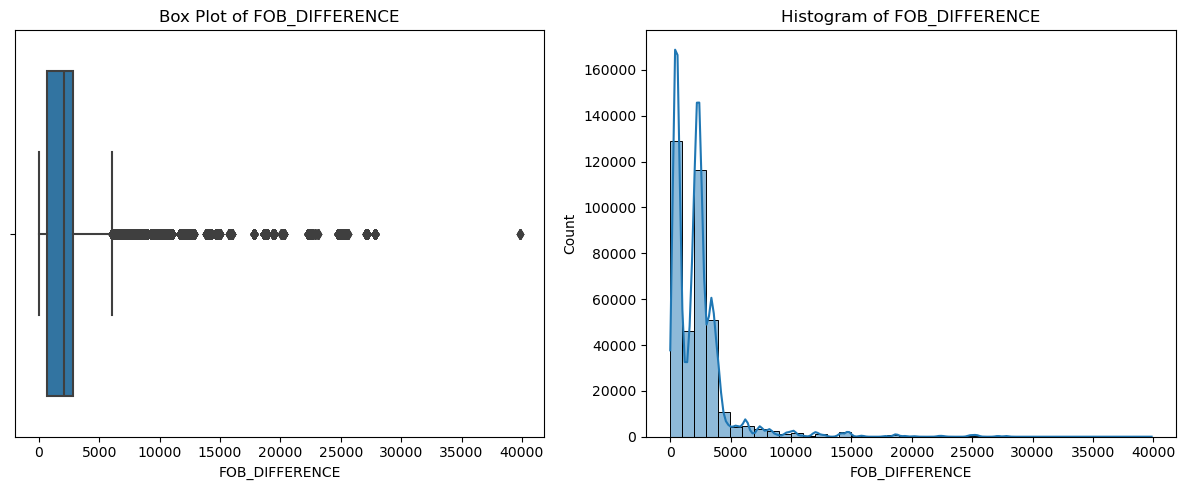

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=combined['FOB_DIFFERENCE'], ax=axes[0])
axes[0].set_title('Box Plot of FOB_DIFFERENCE')

# Histogram
sns.histplot(combined["FOB_DIFFERENCE"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of FOB_DIFFERENCE')

plt.tight_layout()
plt.show()

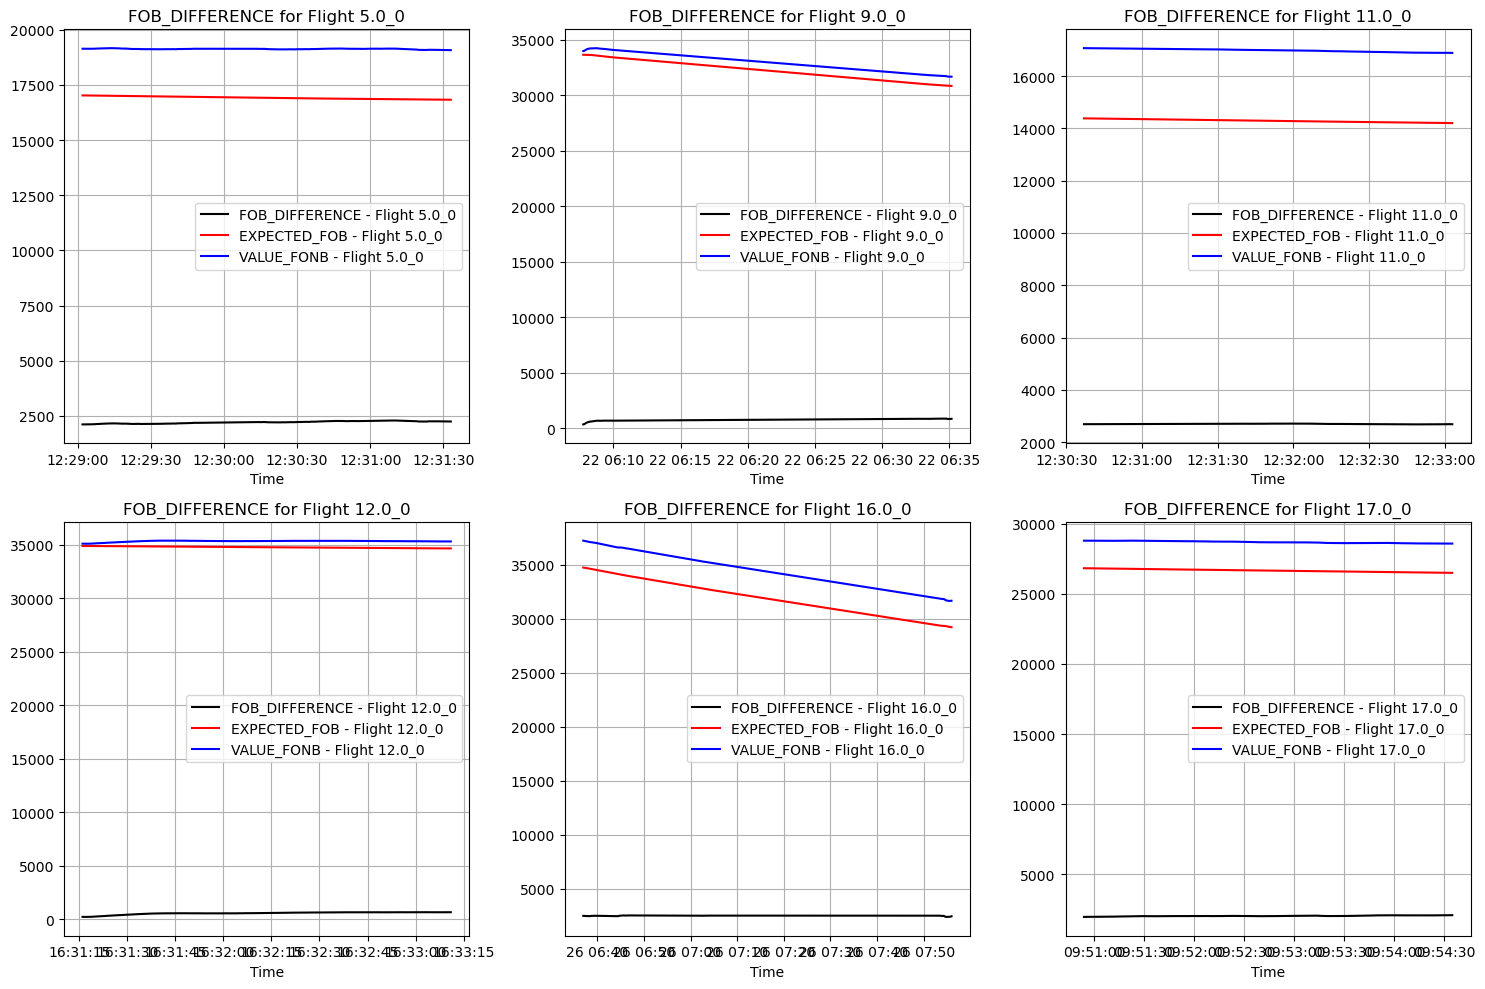

In [74]:
# Plotting FOB Difference in Unique Fights
# =======================================
flights_to_plot = combined['FLIGHT_ID'].unique()[:7]

counter = 0

rows = 2  
cols = 3 

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# For each unique flight
for idx, flight in enumerate(flights_to_plot[1:]):  # skipping the first flight
    # Filter data for that flight
    flight_data = combined[combined['FLIGHT_ID'] == flight]
    
    # Select the current subplot axis
    ax = axes[idx]
    
    ax.plot(flight_data.index, flight_data['FOB_DIFFERENCE'], label=f'FOB_DIFFERENCE - Flight {flight}', color='black')
    ax.plot(flight_data.index, flight_data['EXPECTED_FOB'], label=f'EXPECTED_FOB - Flight {flight}', color='red')
    ax.plot(flight_data.index, flight_data['VALUE_FOB'], label=f'VALUE_FONB - Flight {flight}', color='blue')

    ax.legend()
    
    ax.set_title(f'FOB_DIFFERENCE for Flight {flight}')
    ax.set_xlabel('Time')
    
    ax.grid(True)

plt.tight_layout()

plt.show()

### Left Wing, Right Wing Discrepancy

In [75]:
combined['LW_RW_DIFF'].describe()

count    376554.000000
mean        213.144720
std         217.250952
min           0.000000
25%          83.000000
50%         171.000000
75%         297.000000
max        5340.000000
Name: LW_RW_DIFF, dtype: float64

In [76]:
combined['TOTAL_FUEL_RW'].describe()

count    376554.000000
mean      11994.836255
std        3356.889396
min           0.000000
25%        9383.000000
50%       12151.000000
75%       15009.000000
max       18392.000000
Name: TOTAL_FUEL_RW, dtype: float64

In [77]:
combined['TOTAL_FUEL_LW'].describe()

count    376554.000000
mean      12063.996245
std        3350.684237
min           0.000000
25%        9493.000000
50%       12267.000000
75%       15064.000000
max       18656.000000
Name: TOTAL_FUEL_LW, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


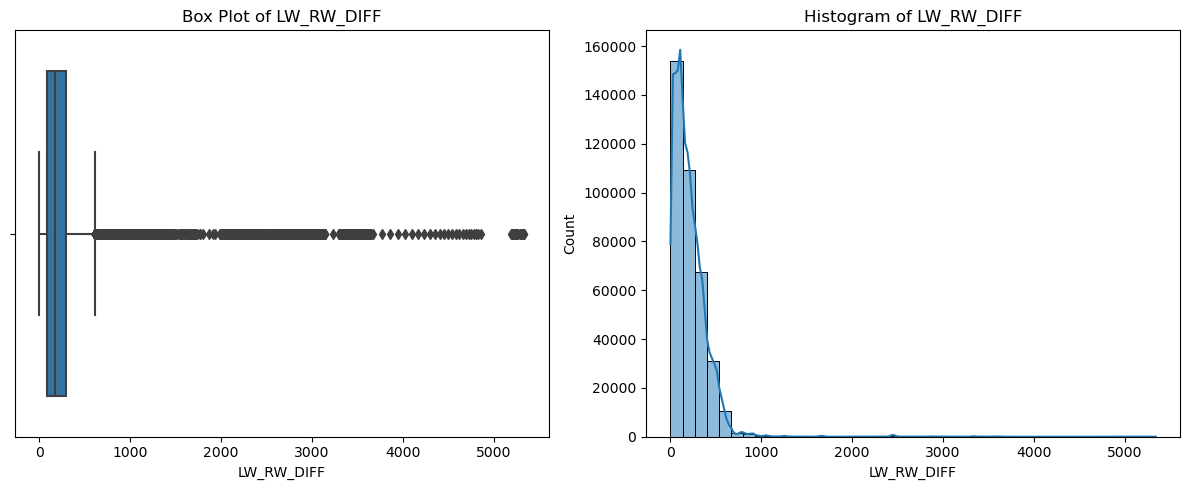

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=combined['LW_RW_DIFF'], ax=axes[0])
axes[0].set_title('Box Plot of LW_RW_DIFF')

# Histogram
sns.histplot(combined["LW_RW_DIFF"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of LW_RW_DIFF')

plt.tight_layout()
plt.show()

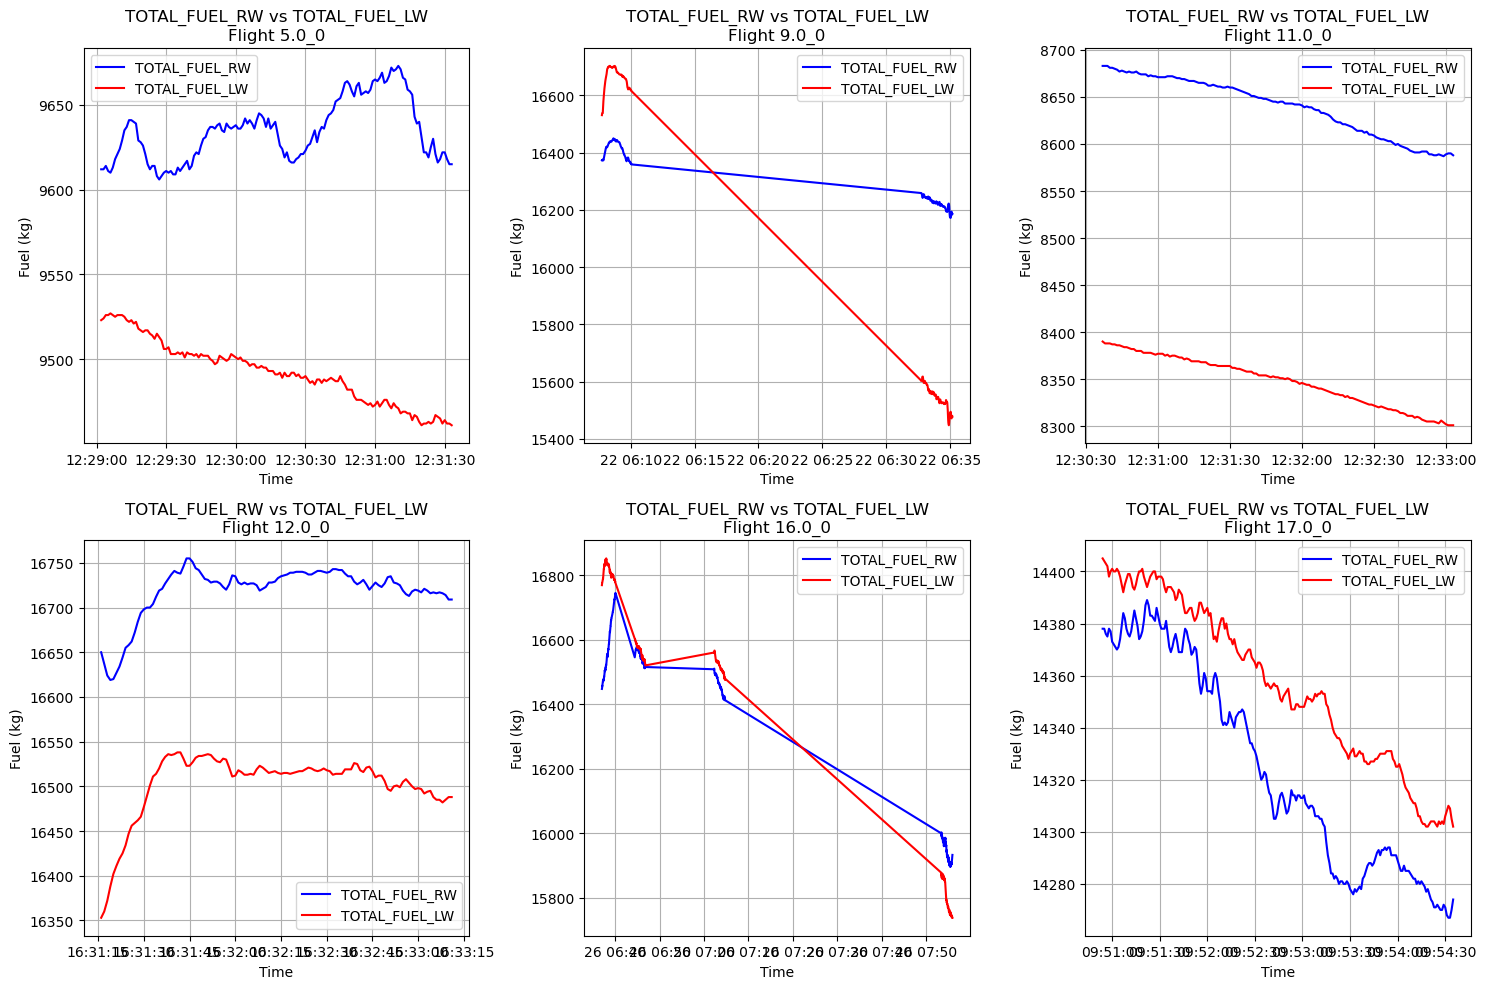

In [79]:
# Left Wing vs Right Wing Fuel Imbalance
# ======================================
counter = 0

rows = 2  
cols = 3

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (if it's 2D)
axes = axes.flatten()

# For each unique flight
for idx, flight in enumerate(flights_to_plot[1:]):  # skipping the first flight
    # Filter data for that flight
    flight_data = combined[combined['FLIGHT_ID'] == flight]
    
    # Select the current subplot axis
    ax = axes[idx]
    
    # Plot TOTAL_FUEL_RW vs TOTAL_FUEL_LW
    ax.plot(flight_data.index, flight_data['TOTAL_FUEL_RW'], label='TOTAL_FUEL_RW', color='blue')
    ax.plot(flight_data.index, flight_data['TOTAL_FUEL_LW'], label='TOTAL_FUEL_LW', color='red')
    
    ax.set_title(f'TOTAL_FUEL_RW vs TOTAL_FUEL_LW\nFlight {flight}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Fuel (kg)')
    
    ax.legend()
    ax.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

### Discrepancy between given `VALUE_FOB` and our own calcuations of fuel on board `FUEL_IN_TANKS`

In [80]:
# Total amount of fuel in tanks
combined['FUEL_IN_TANKS'] = combined['VALUE_FUEL_QTY_CT'] + combined['VALUE_FUEL_QTY_FT1'] + combined['VALUE_FUEL_QTY_FT2'] + combined['VALUE_FUEL_QTY_FT3'] + combined['VALUE_FUEL_QTY_FT4'] + combined['VALUE_FUEL_QTY_LXT'] + combined['VALUE_FUEL_QTY_RXT']

# Difference between our calcuations and given calculations
combined['CALC_VALUE_FOB_DIFF'] =  combined['FUEL_IN_TANKS'] - combined['VALUE_FOB']

In [81]:
combined['VALUE_FOB'].describe()

count    376554.000000
mean      24758.041319
std        7745.473622
min           0.000000
25%       18879.250000
50%       24450.000000
75%       30285.000000
max       48403.000000
Name: VALUE_FOB, dtype: float64

In [82]:
combined['FUEL_IN_TANKS'].describe()

count    376554.000000
mean      24760.424630
std        7744.963226
min           0.000000
25%       18881.000000
50%       24452.000000
75%       30287.000000
max       48404.000000
Name: FUEL_IN_TANKS, dtype: float64

In [83]:
combined['CALC_VALUE_FOB_DIFF'].describe()

count    376554.000000
mean          2.383310
std          86.638497
min         -30.000000
25%           1.000000
50%           2.000000
75%           3.000000
max       23777.000000
Name: CALC_VALUE_FOB_DIFF, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


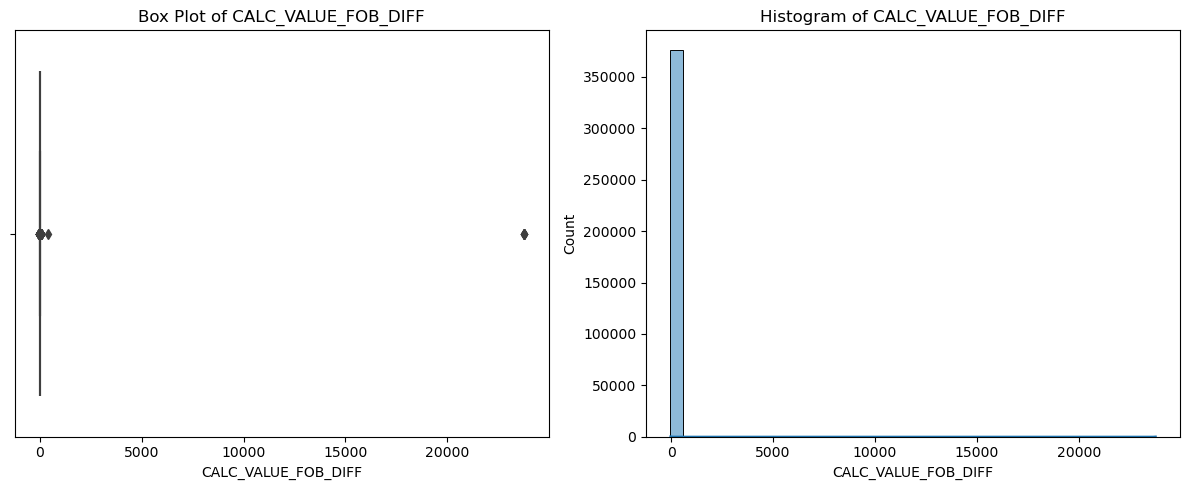

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=combined['CALC_VALUE_FOB_DIFF'], ax=axes[0])
axes[0].set_title('Box Plot of CALC_VALUE_FOB_DIFF')

# Histogram
sns.histplot(combined["CALC_VALUE_FOB_DIFF"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of CALC_VALUE_FOB_DIFF')

plt.tight_layout()
plt.show()

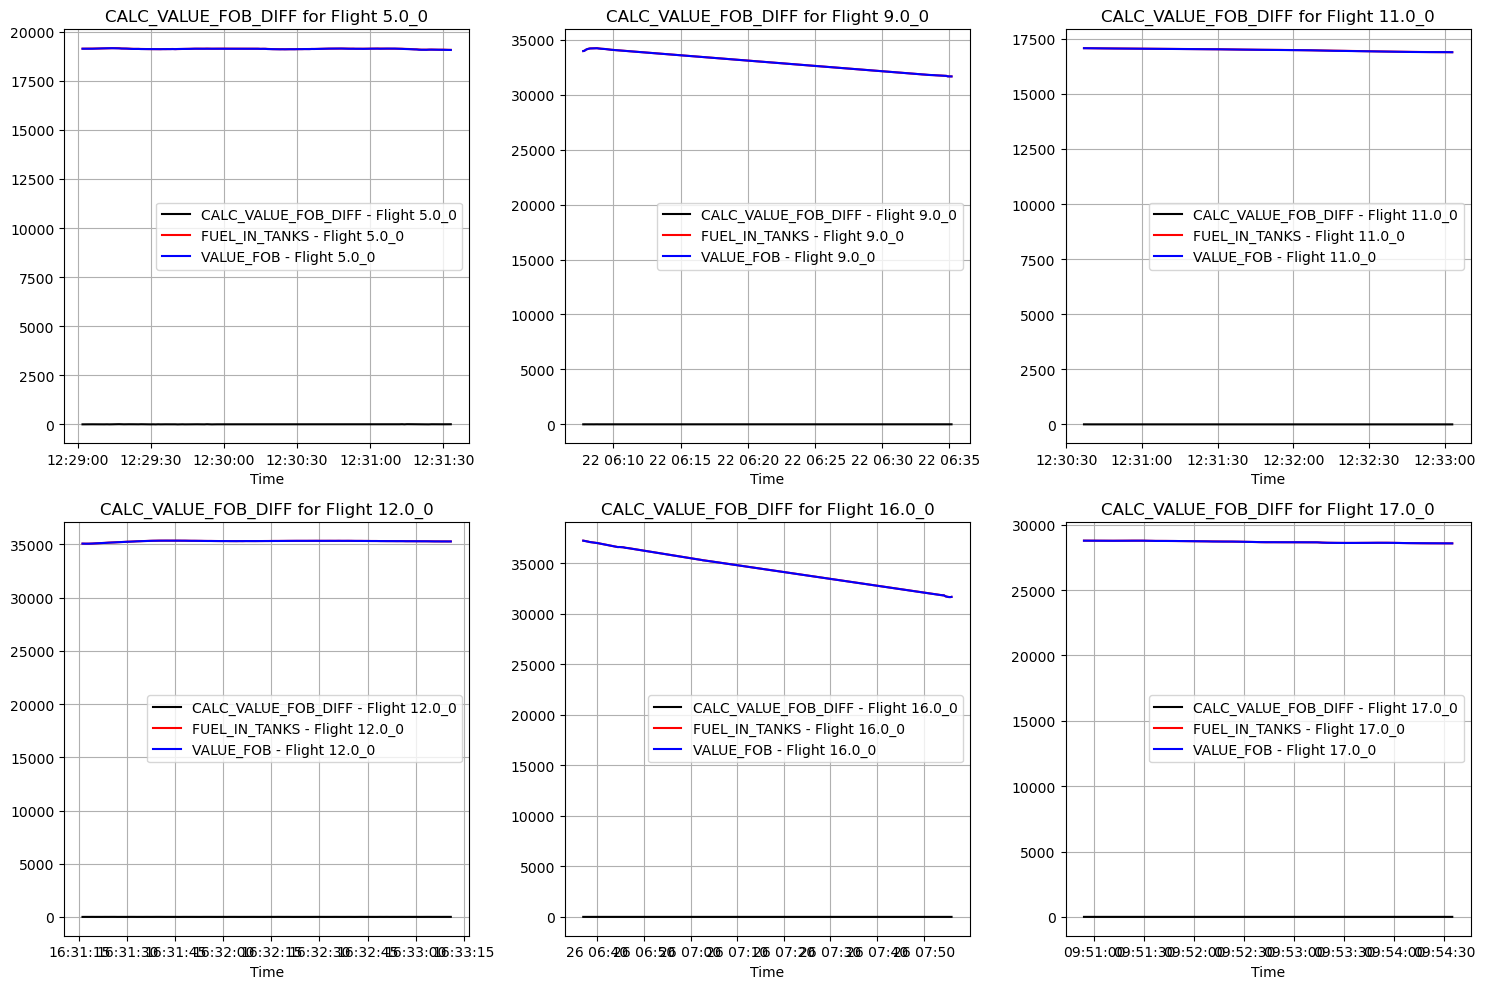

In [85]:
# Plotting FOB Difference in Unique Fights
# =======================================
flights_to_plot = combined['FLIGHT_ID'].unique()[:7]

counter = 0

rows = 2  
cols = 3 

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# For each unique flight
for idx, flight in enumerate(flights_to_plot[1:]):  # skipping the first flight
    # Filter data for that flight
    flight_data = combined[combined['FLIGHT_ID'] == flight]
    
    # Select the current subplot axis
    ax = axes[idx]
    
    ax.plot(flight_data.index, flight_data['CALC_VALUE_FOB_DIFF'], label=f'CALC_VALUE_FOB_DIFF - Flight {flight}', color='black')
    ax.plot(flight_data.index, flight_data['FUEL_IN_TANKS'], label=f'FUEL_IN_TANKS - Flight {flight}', color='red')
    ax.plot(flight_data.index, flight_data['VALUE_FOB'], label=f'VALUE_FOB - Flight {flight}', color='blue')

    ax.legend()
    
    ax.set_title(f'CALC_VALUE_FOB_DIFF for Flight {flight}')
    ax.set_xlabel('Time')
    
    ax.grid(True)

plt.tight_layout()

plt.show()

# Exporting to `combined.csv`

In [86]:
# Save the DataFrame as a CSV
combined.to_csv("combined.csv")